# Práctica 1: Flujo de cargas (2025-GDEE)
Adaptación a python con PyPSA

In [ ]:
import pandas as pd 
import numpy as np
import readFC
import re
import matplotlib.pyplot as plt 
import seaborn as sns

In [51]:
from readFC import U_arg, extraer_potencia_linea, extraer_potencia_trafo
import numpy as np
import pandas as pd
import re

# Genera los nombres de archivo como strings: "5.3", "5.4", ..., "9.9"
archivos = [f"{x:.1f}" for x in np.arange(5.2, 9.2, 0.1)]

# Definir las líneas y el sentido de potencia a extraer
lineas_info = [
    {"numero": 1, "columna": 5, "sentido": "P(B->A)", "sentido_Q": "Q(B->A)"},
    {"numero": 2, "columna": 5, "sentido": "P(B->A)", "sentido_Q": "Q(B->A)"},
    {"numero": 3, "columna": 3, "sentido": "P(A->B)", "sentido_Q": "Q(A->B)"}
]

# Lista para almacenar los datos de todos los archivos
todas_las_filas = []

for archivo in archivos:
    tensiones = []
    angulos = []
    pgen_nudo1 = None
    perdidas_activa = None
    perdidas_reactiva = None
    potencias_lineas = []
    potencias_lineas_Q = []
    # Barrer todos los nudos (del 1 al 5) y almacenar resultados
    for n in range(1, 6):
        try:
            tension, angulo = U_arg(archivo, n)
        except Exception:
            tension, angulo = float('nan'), float('nan')
        tensiones.append(tension)
        angulos.append(angulo)
    
    # Extraer Pgen de Nudo1 y Pérdidas de activa
    try:
        with open(archivo, encoding="latin1") as f:
            lines = f.readlines()
        start = None
        for i, line in enumerate(lines):
            if "---------- RESULTADOS DEL FLUJO DE CARGAS ----------" in line:
                start = i
                break
        if start is not None:
            for line in lines[start:]:
                if line.strip().startswith("Nudo1"):
                    partes = line.split()
                    if len(partes) > 4:
                        pgen_nudo1 = float(partes[4])
                # Buscar pérdidas de activa
                match = re.search(r"de activa=\s*([\d\.\-Ee]+)", line)
                if match:
                    perdidas_activa = float(match.group(1))
                match = re.search(r"de reactiva=\s*([\d\.\-Ee]+)", line)
                if match:
                    perdidas_reactiva = float(match.group(1))
    except Exception:
        pgen_nudo1 = float('nan')
        perdidas_activa = float('nan')
        perdidas_reactiva = float('nan')
    
    # Extraer potencias de las líneas indicadas (activa y reactiva)
    for info in lineas_info:
        try:
            valor_P = extraer_potencia_linea(archivo, info["numero"], info["columna"])
        except Exception:
            valor_P = float('nan')
        potencias_lineas.append(valor_P)
        try:
            # Se asume que la columna de Q es la siguiente a la de P
            valor_Q = extraer_potencia_linea(archivo, info["numero"], info["columna"] + 1)
        except Exception:
            valor_Q = float('nan')
        potencias_lineas_Q.append(valor_Q)
    
    # Extraer P(Prim.) y Q(Prim.) de Trafo1 y Trafo2
    try:
        p_prim_1 = extraer_potencia_trafo(archivo, 1, 3)
    except Exception:
        p_prim_1 = float('nan')
    try:
        q_prim_1 = extraer_potencia_trafo(archivo, 1, 4)
    except Exception:
        q_prim_1 = float('nan')
    try:
        p_prim_2 = extraer_potencia_trafo(archivo, 2, 3)
    except Exception:
        p_prim_2 = float('nan')
    try:
        q_prim_2 = extraer_potencia_trafo(archivo, 2, 4)
    except Exception:
        q_prim_2 = float('nan')
    
    # Construir la fila para este archivo
    fila = []
    for n in range(1, 6):
        fila.append(tensiones[n-1])
        fila.append(angulos[n-1])
    fila.append(pgen_nudo1)
    fila.append(perdidas_activa)
    fila.append(perdidas_reactiva)
    fila.extend(potencias_lineas)
    fila.extend(potencias_lineas_Q)
    fila.append(p_prim_1)
    fila.append(q_prim_1)
    fila.append(p_prim_2)
    fila.append(q_prim_2)
    todas_las_filas.append(fila)

# Crear columnas compactas: U1, θ1, ..., U5, θ5, Pgen_N1, Pperdida, Qperdida,
# P(B->A)_L1, ..., Q(B->A)_L1, ..., P(Prim.)_T1, Q(Prim.)_T1, P(Prim.)_T2, Q(Prim.)_T2
columnas = []
for n in range(1, 6):
    columnas.append(f"U{n}")
    columnas.append(f"θ{n}")
columnas.append("Pgen_N1")
columnas.append("Pperdida")
columnas.append("Qperdida")
for info in lineas_info:
    columnas.append(f"{info['sentido']}_L{info['numero']}")
for info in lineas_info:
    columnas.append(f"{info['sentido_Q']}_L{info['numero']}")
columnas.append("P(Prim.)_T1")
columnas.append("Q(Prim.)_T1")
columnas.append("P(Prim.)_T2")
columnas.append("Q(Prim.)_T2")

# Crear el DataFrame final
df = pd.DataFrame(todas_las_filas, columns=columnas, index=archivos)
df.index.name = "Archivo"

# Guardar en Excel
df.to_excel("tensiones_angulos_varios.xlsx")
# print(df) # visualizar por pantalla

# Visualización: 
Heatmaps separados para tensiones/ángulos y para potencias. 
A continuación se muestran dos heatmaps:

- El primero solo para las tensiones y ángulos (U1, θ1, ..., U5, θ5).

- El segundo para las potencias:
 Pgen_Nudo1, Perdidas_Activa, P(B->A)_L1, P(B->A)_L2, P(A->B)_L3, P(Prim.)_Trafo1, P(Prim.)_Trafo2.

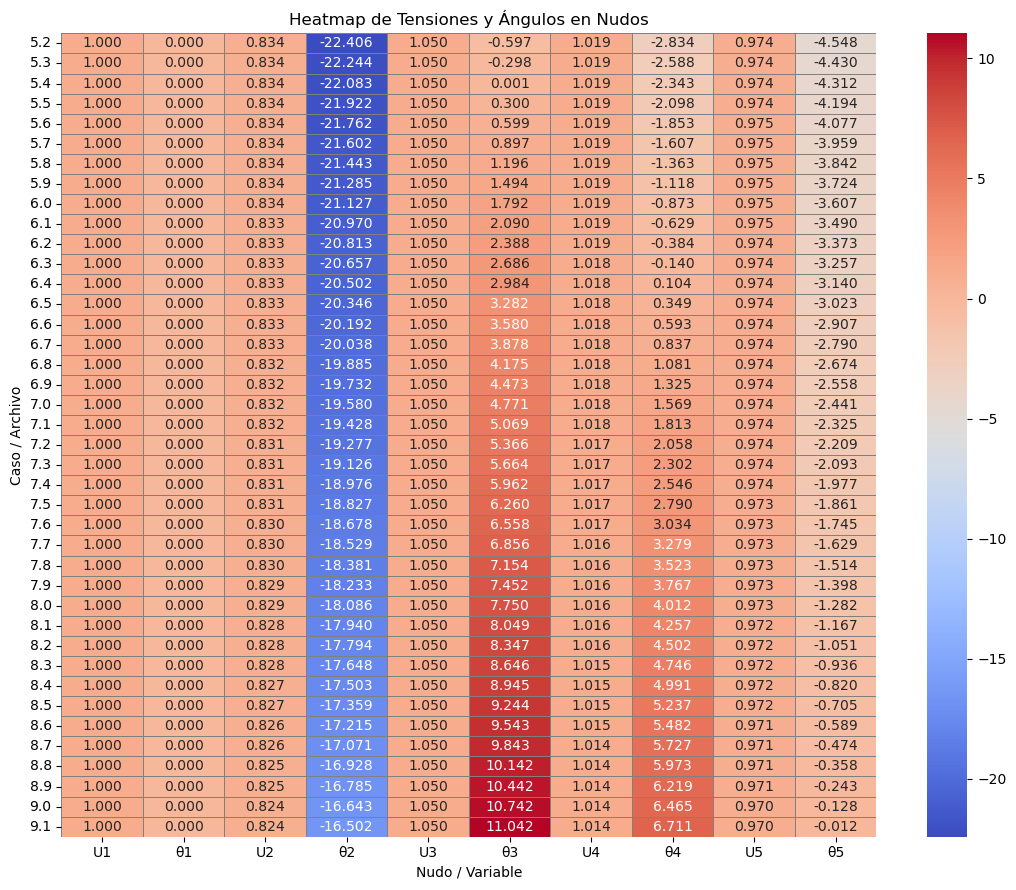

In [52]:
 
# Cargar el archivo Excel generado previamente
df = pd.read_excel("tensiones_angulos_varios.xlsx", index_col=0)

# --- Heatmap 1: Tensiones y ángulos ---
cols_tensiones = [col for col in df.columns 
                    if col.startswith("U") or col.startswith("θ")] 
df_tensiones = df[cols_tensiones]

plt.figure(figsize=(11, 9)) 
sns.heatmap( df_tensiones, 
            cmap="coolwarm", 
            annot=True, 
            fmt=".3f", 
            cbar=True, linewidths=0.5, linecolor='gray' ) 
plt.title("Heatmap de Tensiones y Ángulos en Nudos") 
plt.xlabel("Nudo / Variable") 
plt.ylabel("Caso / Archivo") 
plt.tight_layout() 
plt.show()

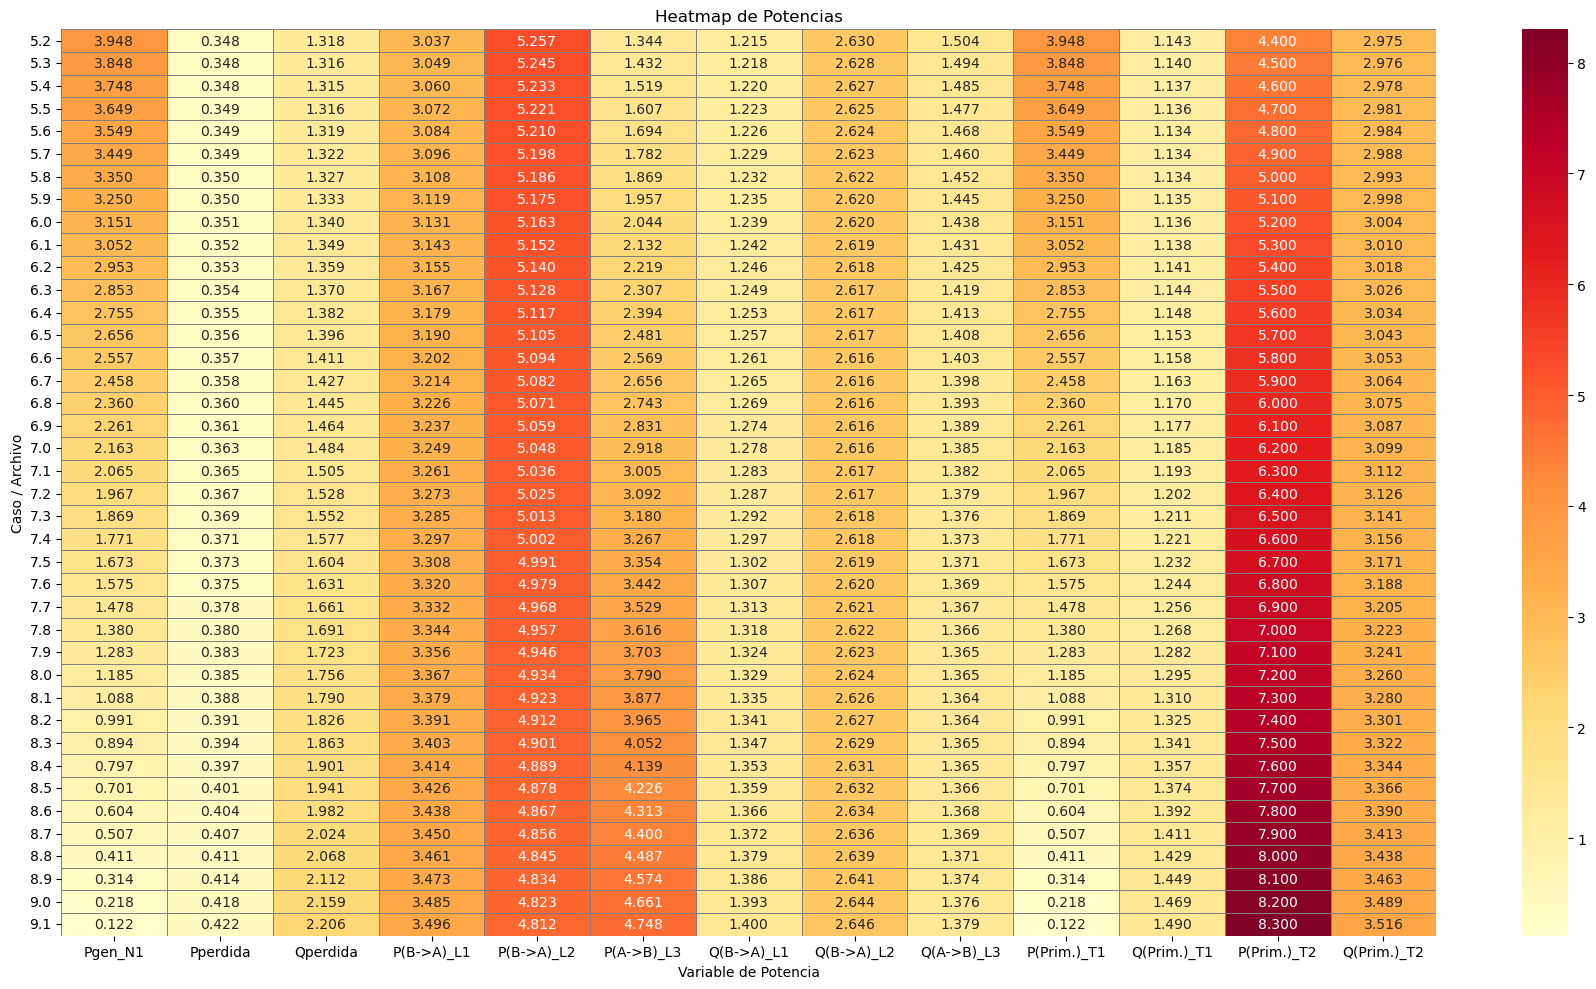

In [53]:
# --- Heatmap 2: Potencias ---
cols_potencias = [col for col in df.columns if col not in cols_tensiones] 
df_potencias = df[cols_potencias]

plt.figure(figsize=(18, 10)) 
sns.heatmap(
    df_potencias,
    cmap="YlOrRd",  # Red-Yellow-Orange color map
    annot=True,
    fmt=".3f",
    cbar=True,
    linewidths=0.5,
    linecolor='gray'
)
plt.title("Heatmap de Potencias") 
plt.xlabel("Variable de Potencia") 
plt.ylabel("Caso / Archivo") 
plt.tight_layout() 
plt.show()
